In [1]:
import logging
import os

import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pyro

from utils import *

/Users/wanhr/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
filename = "../data/Game_Streaming/GeForce_Now/GeForce_Now_1.csv"
local_ip = "10.215.173.1"

In [3]:
df = load_csv(filename)
# stats_src_ip(df)
# stats_dst_ip(df)
dl_pkts = extract_dl_pkt_interval_time(df, local_ip)
ul_pkts = extract_ul_pkt_interval_time(df, local_ip)

In [4]:
dl_pkt_interval = dl_pkts[dl_pkts[:, 0] < 0.05, :] * 1000 # in ms
ul_pkt_interval = ul_pkts[ul_pkts[:, 0] < 0.05, :] * 1000 # in ms

dl_count, dl_bins_count = np.histogram(dl_pkt_interval[:, 0], bins=10000) 
dl_pdf = dl_count / sum(dl_count) 
dl_cdf = np.cumsum(dl_pdf) 

ul_count, ul_bins_count = np.histogram(ul_pkt_interval[:, 0], bins=10000) 
ul_pdf = ul_count / sum(ul_count) 
ul_cdf = np.cumsum(ul_pdf) 

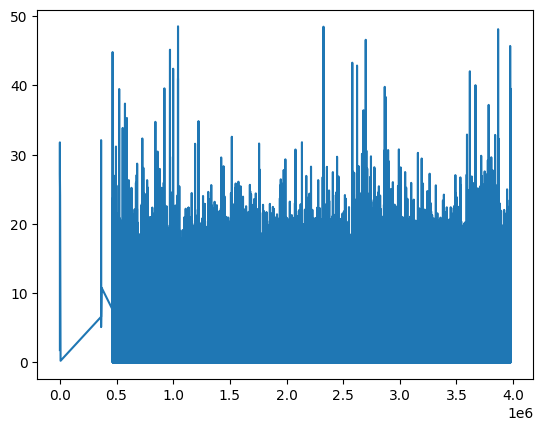

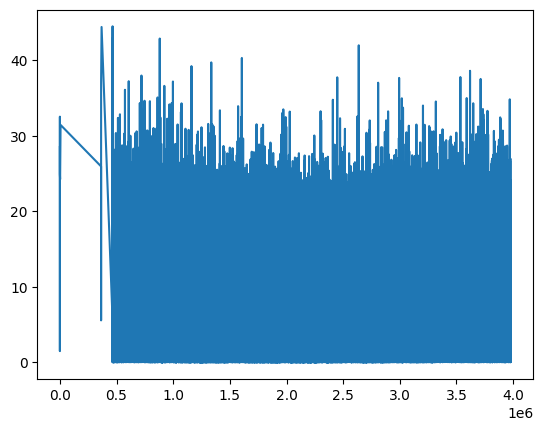

In [5]:
plt.figure()
plt.plot(dl_pkt_interval[:, 1], dl_pkt_interval[:, 0])

plt.figure()
plt.plot(ul_pkt_interval[:, 1], ul_pkt_interval[:, 0])

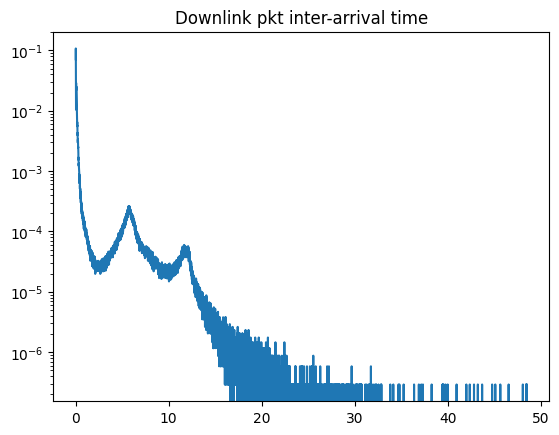

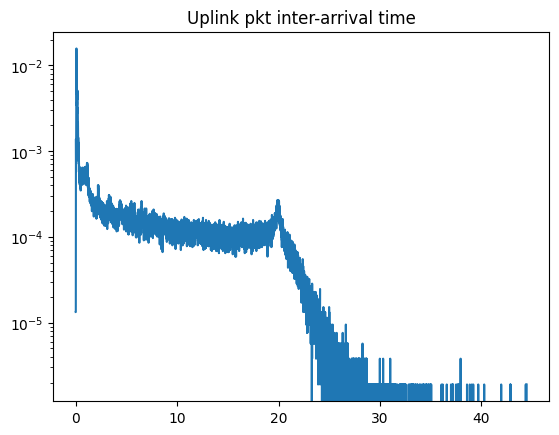

In [6]:
plt.figure()
plt.plot(dl_bins_count[1:], dl_pdf)
plt.yscale("log")
plt.title("Downlink pkt inter-arrival time")

plt.figure()
plt.plot(ul_bins_count[1:], ul_pdf)
plt.yscale("log")
plt.title("Uplink pkt inter-arrival time")

plt.show()

In [7]:
train = torch.tensor(dl_pkt_interval, dtype=torch.float)
pkt_interval, time, pkt_size = train[:, 0], train[:, 1], train[:, 2]

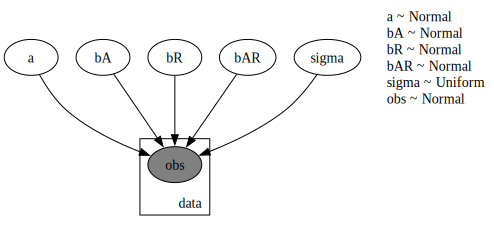

In [24]:
import pyro.distributions as dist
import pyro.distributions.constraints as constraints

def model(time, pkt_size, pkt_interval=None):
    a = pyro.sample("a", dist.Normal(0., 10.))
    b_a = pyro.sample("bA", dist.Normal(0., 10.))
    b_r = pyro.sample("bR", dist.Normal(0., 10.))
    b_ar = pyro.sample("bAR", dist.Normal(0., 10.))
    sigma = pyro.sample("sigma", dist.Uniform(0., 10.))

    mean = a + b_a * time + b_r * pkt_size + b_ar * pkt_size * time

    with pyro.plate("data", len(time)):
        return pyro.sample("obs", dist.Normal(mean, sigma), obs=pkt_interval)

pyro.render_model(model, model_args=(time, pkt_size, pkt_interval), render_distributions=True)

In [25]:
def custom_guide(time, pkt_size, pkt_interval=None):
    a_loc = pyro.param('a_loc', lambda: torch.tensor(0.))
    a_scale = pyro.param('a_scale', lambda: torch.tensor(1.),
                         constraint=constraints.positive)
    sigma_loc = pyro.param('sigma_loc', lambda: torch.tensor(0.))
    weights_loc = pyro.param('weights_loc', lambda: torch.randn(3))
    weights_scale = pyro.param('weights_scale', lambda: torch.ones(3),
                               constraint=constraints.positive)
    a = pyro.sample("a", dist.Normal(a_loc, a_scale))
    b_a = pyro.sample("bA", dist.Normal(weights_loc[0], weights_scale[0]))
    b_r = pyro.sample("bR", dist.Normal(weights_loc[1], weights_scale[1]))
    b_ar = pyro.sample("bAR", dist.Normal(weights_loc[2], weights_scale[2]))
    sigma = pyro.sample("sigma", dist.LogNormal(sigma_loc, torch.tensor(0.05)))  # fixed scale for simplicity
    return {"a": a, "b_a": b_a, "b_r": b_r, "b_ar": b_ar, "sigma": sigma}

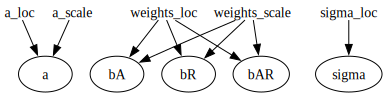

In [26]:
pyro.render_model(custom_guide, model_args=(time, pkt_size, pkt_interval), render_params=True)

In [27]:
adam = pyro.optim.Adam({"lr": 0.02})
elbo = pyro.infer.Trace_ELBO()
svi = pyro.infer.SVI(model, custom_guide, adam, elbo)

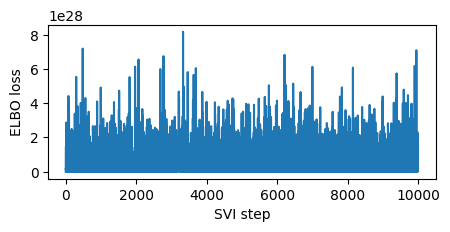

In [28]:
smoke_test = ('CI' in os.environ)

pyro.clear_param_store()

# These should be reset each training loop.
auto_guide = pyro.infer.autoguide.AutoNormal(model)
adam = pyro.optim.Adam({"lr": 0.02})  # Consider decreasing learning rate.
elbo = pyro.infer.Trace_ELBO()
svi = pyro.infer.SVI(model, auto_guide, adam, elbo)

losses = []
for step in range(10000 if not smoke_test else 2):  # Consider running for more steps.
    loss = svi.step(time, pkt_size, pkt_interval)
    losses.append(loss)
    if step % 100 == 0:
        logging.info("Elbo loss: {}".format(loss))

plt.figure(figsize=(5, 2))
plt.plot(losses)
plt.xlabel("SVI step")
plt.ylabel("ELBO loss");

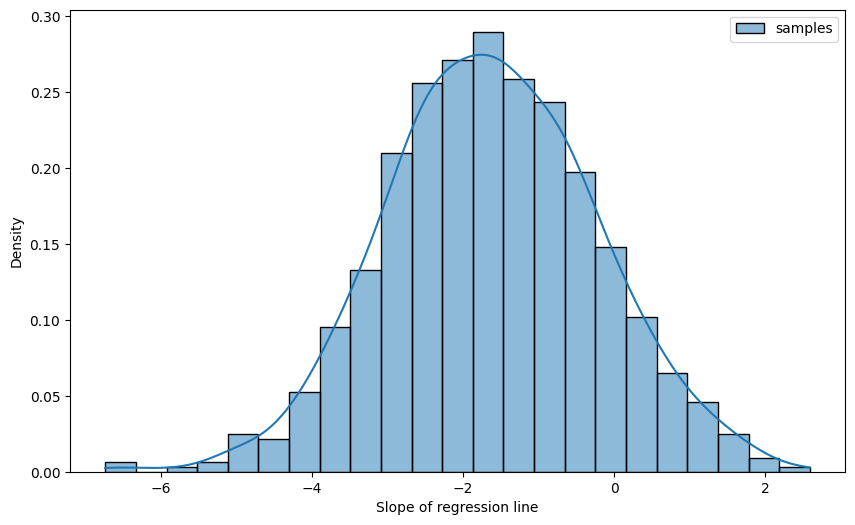

In [33]:
with pyro.plate("samples", 800, dim=-1):
    samples = custom_guide(time, pkt_size)

gamma_result = samples["b_r"] + samples["b_ar"]
fig = plt.figure(figsize=(10, 6))
sns.histplot(gamma_result.detach().cpu().numpy(), kde=True, stat="density", label="samples")
plt.xlabel("Slope of regression line")
plt.legend()
plt.show()